# Librerías

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from umap import UMAP

In [3]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

import pandas as pd 
import numpy as np
import scanpy as sc 
import h5py 

import warnings
warnings.filterwarnings('ignore')

In [4]:
from clustering import * 

# Lectura de datos
Se leen los datos del espacio latente y los datos iniciales para comparar los clusters

In [5]:
datasets = ['10PBMC', 'HumanLiver', 'Macosko']
z_dict = {dataset: pd.read_csv('latentVectors/Z_' + dataset + '.csv').drop('Unnamed: 0', axis = 1) for dataset in datasets}

In [6]:
raw_data = {}

data10x = h5py.File('../Tests-GMM/data/Small_Datasets/' + '10X_PBMC_select_2100_top2000.h5')
raw_data['10PBMC'] = {'X': np.array(data10x['X']), 'y': np.array(data10x['Y'])}

dataLiver = h5py.File('../Tests-GMM/data/Small_Datasets/' + 'HumanLiver_counts_top5000.h5')
raw_data['HumanLiver'] = {'X': np.array(dataLiver['X']), 'y': np.array(dataLiver['Y'])}

dataMacosko = h5py.File('../Tests-GMM/data/Small_Datasets/' + 'Macosko_mouse_retina.h5')
raw_data['Macosko'] = {'X': np.array(dataMacosko['X']), 'y': np.array(dataMacosko['Y'])}

# Autoencoder + Otros algorítmos

In [7]:
# KMeans 
for d in datasets:
    y = raw_data[d]['y']
    z = z_dict[d]

    _, metrics = model_KMeans(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {d} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10PBMC ---- ACC 0.8342857142857143. NMI 0.7945950255225135. ARI 0.7823253661758172.

Modelo HumanLiver ---- ACC 0.6649692089057319. NMI 0.7492879268147782. ARI 0.6501670778552497.

Modelo Macosko ---- ACC 0.4611342387224459. NMI 0.7036191317835994. ARI 0.4155965625972164.


In [8]:
# BIRCH 
for d in datasets:    
    y = raw_data[d]['y']
    z = z_dict[d]

    _, _, _, metrics = model_BIRCH(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {d} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10PBMC ---- ACC 0.8433333333333334. NMI 0.7940579403464676. ARI 0.7847818557637792.

Modelo HumanLiver ---- ACC 0.8739933680720038. NMI 0.8603722693273502. ARI 0.919355314561156.

Modelo Macosko ---- ACC 0.5789940626492869. NMI 0.6559126237235008. ARI 0.5807783065098687.


In [9]:
# DBSCAN 
for d in datasets:
    y = raw_data[d]['y']
    z = z_dict[d]

    _, _, _, metrics = model_DBSCAN(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {d} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10PBMC ---- ACC 0.6638095238095238. NMI 0.645644777875103. ARI 0.4641847502711399.

Modelo HumanLiver ---- ACC 0.8552818569398389. NMI 0.8668716831922844. ARI 0.8912799221896549.


# KNN Graph

In [27]:
knn_graph_dict = {}
for k in datasets:
    z = z_dict[k]
    # Define the number of neighbors (K) for the KNN graph
    K = 5

    # Compute pairwise distances between points (can use other distance metrics as well)
    #distances = np.array([[euclidean(x1, x2) for x2 in z] for x1 in z])

    # Create the KNN graph
    knn_graph = kneighbors_graph(z, K, mode='connectivity', metric='euclidean')
    knn_graph_dict[k] = knn_graph

In [28]:
# Miramos ls dispersión de las matrices KNN
for k in datasets:
    knn_graph = knn_graph_dict[k]
    print(f'Dispersión {k}: {round(len(knn_graph.nonzero()[0]) / knn_graph.shape[0]**2 * 100,3)}%')

Dispersión 10PBMC: 0.238%
Dispersión HumanLiver: 0.059%
Dispersión Macosko: 0.034%


[Text(0.5, 1.0, 'HumanLiver')]

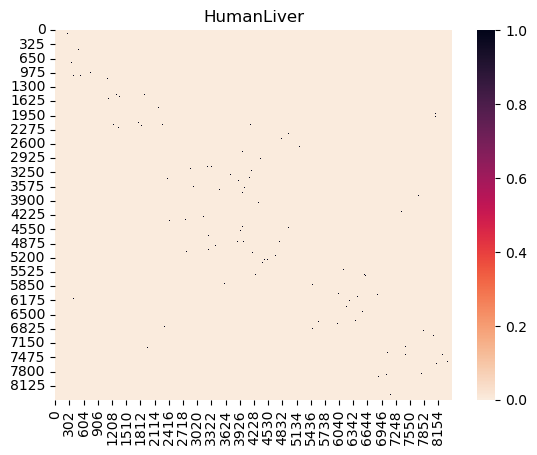

In [29]:
# fig, axes = plt.subplots(ncols = 3, figsize = (15,5))
c = sns.color_palette("rocket_r", as_cmap=True)
# for k, ax in zip(datasets, axes):
knn_graph = knn_graph_dict['HumanLiver']

sns.heatmap(knn_graph.todense(), cmap = c).set(title='HumanLiver')

In [30]:
G = nx.Graph(knn_graph)

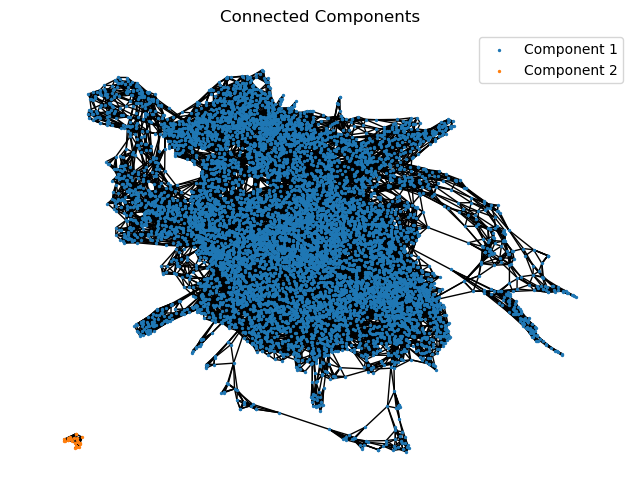

In [31]:
# Find the connected components
connected_components = list(nx.connected_components(G))

# Create a mapping of nodes to their respective connected component index
component_mapping = {}
for i, component in enumerate(connected_components):
    for node in component:
        component_mapping[node] = i

# Generate colors for each connected component
num_components = len(connected_components)
color_map = [f"C{i}" for i in range(num_components)]

# Draw the graph with connected components colored differently
pos = nx.fruchterman_reingold_layout(G)
plt.figure(figsize=(8, 6))
for i in range(num_components):
    nodes = [node for node in G.nodes() if component_mapping[node] == i]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color_map[i], node_size=2, label=f"Component {i+1}")
nx.draw_networkx_edges(G, pos)
plt.legend()
plt.title("Connected Components")
plt.axis("off")
plt.show()

In [32]:
n_labels = num_components
n_clusters = len(set(raw_data['HumanLiver']['y']))

connected_components = list(nx.connected_components(G))
principal_connected_component = connected_components[0]

while n_labels < n_clusters:
    # Find the connected components
    edge_betweenness = nx.edge_betweenness_centrality(G)
    max_betweenness_edge = max(edge_betweenness, key=edge_betweenness.get)

    G.remove_edge(*max_betweenness_edge)

    connected_components = list(nx.connected_components(G))

    n_labels = len(connected_components)

    print(n_labels)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


KeyboardInterrupt: 

In [18]:
lables = []
s = pd.Series()
for k, nodes in enumerate(connected_components):
    for n in nodes:
        s.loc[n] = k
labels = s.sort_index().values 

acc = cluster_acc(raw_data['HumanLiver']['y'], labels)
nmi = normalized_mutual_info_score(raw_data['10PBMC']['y'], labels)
ari = adjusted_rand_score(raw_data['HumanLiver']['y'], labels)
acc, nmi, ari

(0.8128571428571428, 0.7966416399741871, 0.7759799529669537)

# PCA + Otros algorítmos

In [9]:
for key, df in raw_data.items():
    X = df['X']
    y = df['y']
    pca = PCA(n_components = 32)
    z = pca.fit_transform(X)

    _, metrics = model_KMeans(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10PBMC ---- ACC 0.36952380952380953. NMI 0.31523169838766363. ARI 0.17784354565230684.

Modelo HumanLiver ---- ACC 0.33183325438180955. NMI 0.20853381774270616. ARI -0.04541530498561132.

Modelo Macosko ---- ACC 0.2989148979731113. NMI 0.40216680994769644. ARI 0.16998802457577986.


In [11]:
for key, df in raw_data.items():
    X = df['X']
    y = df['y']
    pca = PCA(n_components = 32)
    z = pca.fit_transform(X)

    _, _, _, metrics = model_BIRCH(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10PBMC ---- ACC 0.4280952380952381. NMI 0.3842300831476422. ARI 0.2146917392812718.

Modelo HumanLiver ---- ACC 0.46293225959261014. NMI 0.3527755520271388. ARI 0.13951143446889896.

Modelo Macosko ---- ACC 0.4136354330171296. NMI 0.3663521015748183. ARI 0.20904258234309622.


In [13]:
# DBSCAN 
for key, df in raw_data.items():
    X = df['X']
    y = df['y']
    pca = PCA(n_components = 32)
    z = pca.fit_transform(X)

    _, _, _, metrics = model_DBSCAN(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10PBMC ---- ACC 0.44333333333333336. NMI 0.29291532330300724. ARI 0.16680227217368504.

Modelo HumanLiver ---- ACC 0.5313832306963524. NMI 0.3444246373041233. ARI 0.3359652386801703.

Modelo Macosko ---- ACC 0.2746877772469801. NMI 0.05760172701431548. ARI 0.014179235263197072.


# Normalización + PCA + Otros algoritmos

In [6]:
def log_1(x):
    return np.log10(x+1)

for k, d in raw_data.items():
    d['X'] = np.array(list(map(log_1, d['X'])))

In [7]:
for k, d in raw_data.items():
    d['X'] = sc.AnnData(d['X'])
    sc.pp.normalize_total(d['X'])
    d['X'] = d['X'].X

In [53]:
for key, df in raw_data.items():
    X = df['X']
    y = df['y']
    pca = PCA(n_components = 32)
    z = pca.fit_transform(X)

    _, metrics = model_KMeans(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10PBMC ---- ACC 0.7642857142857142. NMI 0.7381460865715457. ARI 0.6536802282153348.

Modelo HumanLiver ---- ACC 0.6149928943628612. NMI 0.7476179945640533. ARI 0.533649733977975.

Modelo Macosko ---- ACC 0.390159011806456. NMI 0.6339673011169997. ARI 0.2775568488113581.


In [54]:
for key, df in raw_data.items():
    X = df['X']
    y = df['y']
    pca = PCA(n_components = 32)
    z = pca.fit_transform(X)

    _, _, _, metrics = model_BIRCH(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10PBMC ---- ACC 0.7342857142857143. NMI 0.7226596749199059. ARI 0.625469828283693.

Modelo HumanLiver ---- ACC 0.8150165798199905. NMI 0.8338586118938114. ARI 0.7716878382451833.

Modelo Macosko ---- ACC 0.5643212993926159. NMI 0.6112211292632272. ARI 0.6078133963818834.


In [ ]:
# DBSCAN 
for key, df in raw_data.items():
    X = df['X']
    y = df['y']
    pca = PCA(n_components = 32)
    z = pca.fit_transform(X)

    _, _, _, metrics = model_DBSCAN(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')

# Normalización + PCA + TSNE + Otros algorítmos

In [7]:
# Modelo 10PBMC ---- ACC 0.6409523809523809. NMI 0.6110452444616548. ARI 0.4698521291082784.

for key, df in raw_data.items():
    if key != '10PBMC':
        X = df['X']
        y = df['y']

        pca = PCA(n_components = 32)
        z = pca.fit_transform(X)

        print('Termino PCA')

        tsne = TSNE(n_components = 2, method='exact')
        z = tsne.fit_transform(z)

        print('Termino Tsne')

        _, metrics = model_KMeans(z, y)
        acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
        print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')

Termino PCA


In [ ]:
# Modelo 10PBMC ---- ACC 0.7819047619047619. NMI 0.6623842358322354. ARI 0.677089284276747.

for key, df in raw_data.items():
    if key != '10PBMC':
        X = df['X']
        y = df['y']
        
        pca = PCA(n_components = 32)
        z = pca.fit_transform(X)

        tsne = TSNE(n_components = 2, method='exact')
        z = tsne.fit_transform(z)

        print('termino tsne')

        _, _, _, metrics = model_BIRCH(z, y)
        acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
        print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')

In [ ]:
# Modelo 10PBMC ---- ACC 0.31333333333333335. NMI 0.07648857911990384. ARI 0.00427178974645301.

# DBSCAN 
for key, df in raw_data.items():
    if key != '10PBMC':
        X = df['X']
        y = df['y']
        
        pca = PCA(n_components = 32)
        z = pca.fit_transform(X)

        tsne = TSNE(n_components = 2, method='exact')
        z = tsne.fit_transform(z)

        _, _, _, metrics = model_DBSCAN(z, y)
        acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
        print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')

# Normalización + UMAP + Otros algorítmos

In [15]:
for key, df in raw_data.items():
    X = df['X']
    y = df['y']
    umap = UMAP(n_components = 32)
    z = umap.fit_transform(X)

    _, metrics = model_KMeans(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10PBMC ---- ACC 0.8052380952380952. NMI 0.7631440939136589. ARI 0.7574353118665893.

Modelo HumanLiver ---- ACC 0.6173614400757934. NMI 0.7640908354742049. ARI 0.5293003180125695.

Modelo Macosko ---- ACC 0.20869446529720875. NMI 0.4317031630749216. ARI 0.14218472371693552.


In [17]:
for key, df in raw_data.items():
    X = df['X']
    y = df['y']
    umap = UMAP(n_components = 32)
    z = umap.fit_transform(X)
    
    _, _, _, metrics = model_BIRCH(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10PBMC ---- ACC 0.809047619047619. NMI 0.7791071331527052. ARI 0.7523270731856561.

Modelo HumanLiver ---- ACC 0.7680009474182852. NMI 0.8046170704133268. ARI 0.7148109357047804.

Modelo Macosko ---- ACC 0.464478263836757. NMI 0.510054260914648. ARI 0.4723294701958693.


In [ ]:
#Modelo 10PBMC ---- ACC 0.6576190476190477. NMI 0.664723296868254. ARI 0.4699387860548075.

# DBSCAN 
for key, df in raw_data.items():
    X = df['X']
    y = df['y']
    umap = UMAP(n_components = 32)
    z = umap.fit_transform(X)

    _, _, _, metrics = model_DBSCAN(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')